## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV


In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

# 1. Подготовка

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [4]:
taxi[:4]

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [7]:
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


# 2. Анализ

In [9]:
taxi.index = taxi['datetime']
taxi.index.is_monotonic

True

### Даты распорложены последовательно 

In [10]:
#taxi = taxi.drop(['datetime'], axis = 1)
taxi = taxi.resample('1H').sum()

### Отображу график заказов всего временного ряда

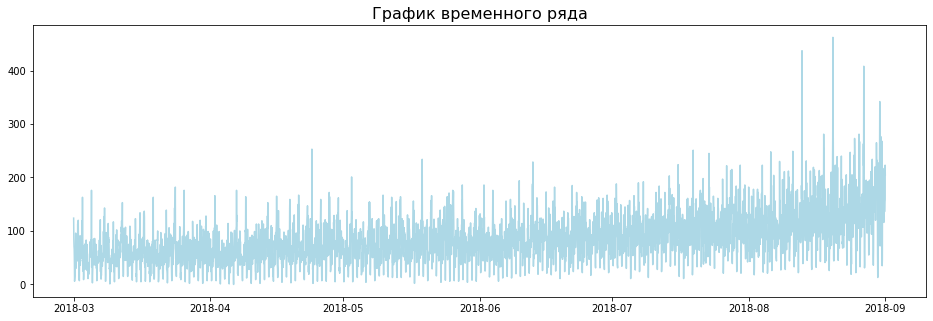

In [11]:
plt.figure(figsize=(16,5))
plt.title('График временного ряда', fontsize=16)
plt.plot( taxi.index, 'num_orders', data=taxi, color='lightblue')
plt.show()

### Так-как явно есть уход вверх, в конце ряда, проверю на тренд.

In [12]:
def moving_average(series, n):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(16,5))
    plt.title("Скользящее среднее\n Размер окна = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

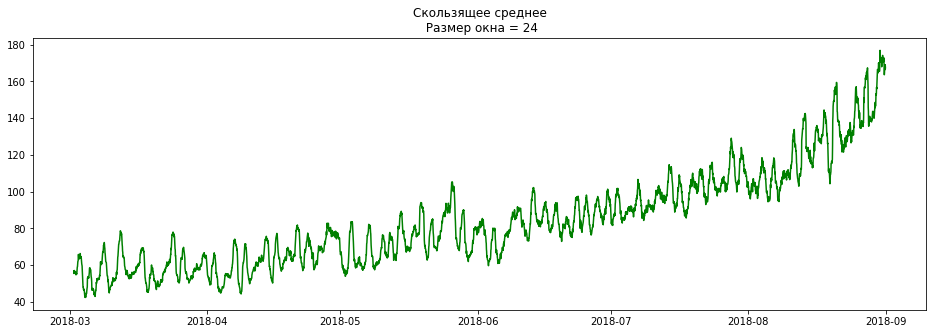

In [13]:
moving_average(taxi.num_orders, 24)

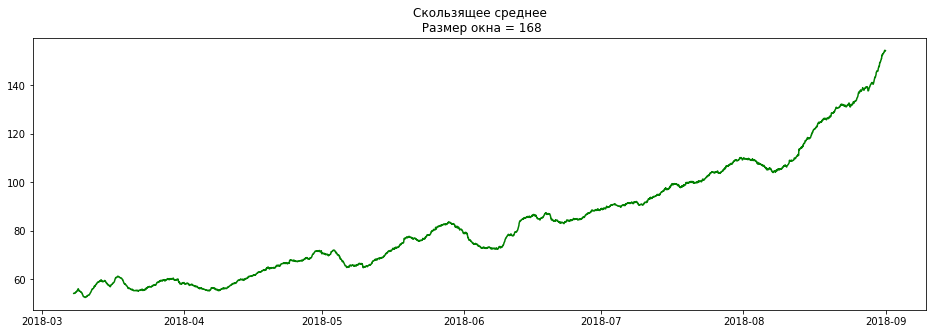

In [14]:
moving_average(taxi.num_orders, 24*7)

### Явно прослеживается годовой восходящий тренд. Также на часовом графике прослеживаются колебания, которые могут быть дневной и недельной сезонностью. Проверю их.

In [18]:
def day(data, rolling):
    day = data.resample('1H').sum()
    #day['mean'] = day['num_orders'].rolling(rolling).mean()
    day['std'] = day['num_orders'].rolling(rolling).std()
    day.plot(figsize=(16,5), title = 'График временного ряда')
    plt.show()
    

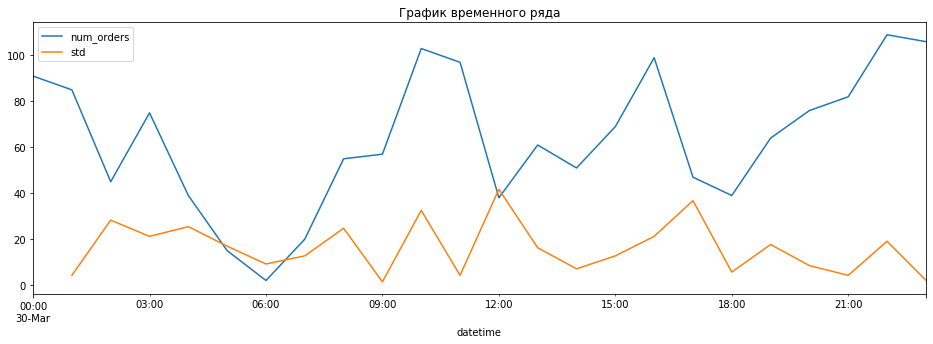

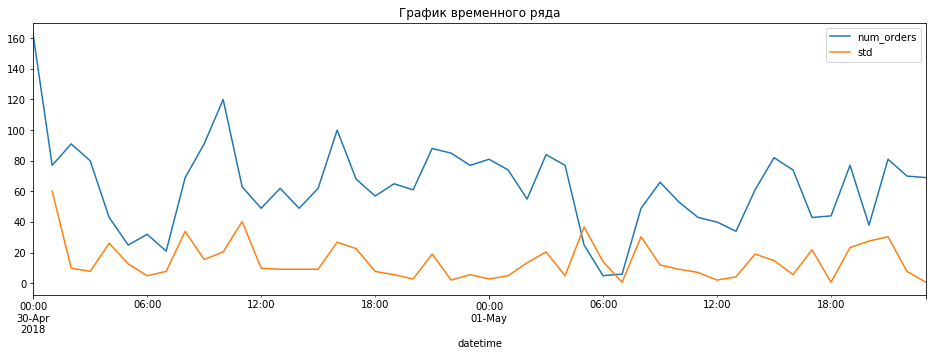

(None, None)

In [27]:
day(taxi['2018-03-30':'2018-03-30'], 2), day(taxi['2018-04-30':'2018-05-01'],2)

### В течении дня наблюдается повышение значения ряда и его падение, также наблюдается сезонность. Прослеживается утреннее падение. Вероятно в течении недели будет своя сезонность. Проверю.

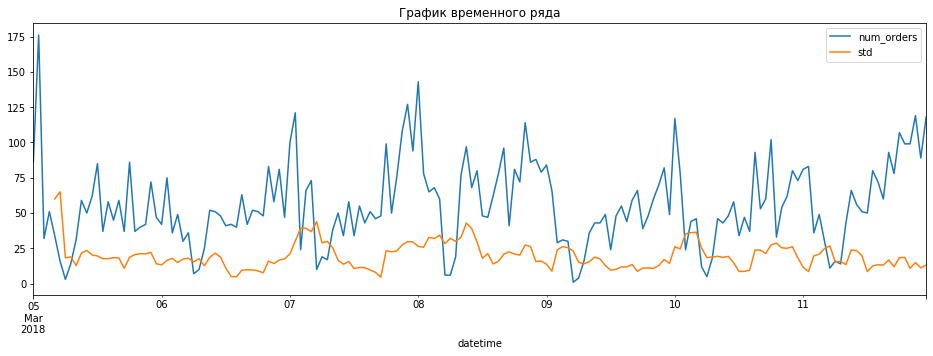

In [29]:
day(taxi['2018-03-05':'2018-03-11'], 5)

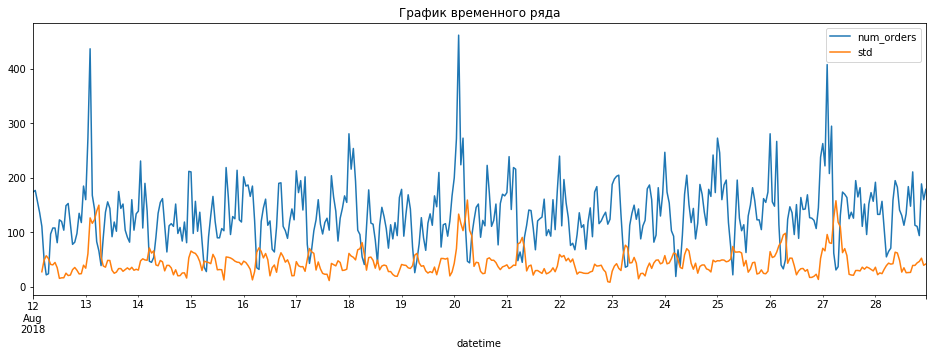

In [38]:
day(taxi['2018-08-12':'2018-08-28'], 5)

### Наблюдается характерный всплеск в воскресенье.

### Вывод
- На графиках присутствукт дневная сезонность (утром вызовов меньше)
- На графиках присутствукт недельная сезонность (к выходным количество вызовов возрастает и в воскресенье есть пик)
- Присутствует тренд

Необходимо создание новых признаков для учета сезонности:
    - день
    - месяц
    - день недели
    - утро
    - выходные

# 3. Обучение

 ### Создам признаки, исходя из понимания сезонности.

In [46]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['is_morning'] = data.hour.isin(range(5,11))*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    features = data.drop(['num_orders'], axis = 1)
    target = data['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(features,  target,
                                                                                  shuffle=False, test_size=0.2)
    
    return features, target, data, features_train, features_test, target_train, target_test

In [47]:
features, target, data, features_train, features_test, target_train, target_test = make_features(taxi, 100, 5)

### Линейная регрессия

In [48]:
model_Linear = LinearRegression().fit(features_train, target_train)
model_Linear_predict = model_Linear.predict(features_train)
print('RMSE:', mean_squared_error(target_train, model_Linear_predict)**0.5)

RMSE: 20.863467544669803


### Градиентный бустинг

In [49]:
gradient_model = GradientBoostingRegressor(random_state=12345).fit(features_train, target_train)
gradient_model_predict = gradient_model.predict(features_train)
print('RMSE:', mean_squared_error(target_train, gradient_model_predict)**0.5)

RMSE: 17.018253178886308


### XGBoost

In [50]:
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test, label=target_test)

params = {'max_depth':10, 
         'eta':.3,
         'silent': 1,
        }
num_round = 100

#cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=num_round)

In [51]:
bst = xgb.train(params, dtrain, num_boost_round=10)

In [52]:
model_XGBoost_predictions = bst.predict(dtrain)
print('RMSE',mean_squared_error(target_train, model_XGBoost_predictions)**0.5)

RMSE 6.898428481037699


### CatBoost

In [53]:
def RMSE(y_actual, y_predict):
    return np.sqrt(mean_squared_error(target_train, model_XGBoost_predictions)**0.5)

my_scorer = make_scorer(RMSE, greater_is_better = False)

params_cat = {'iterations': [100], 'depth':[x for x in range (2,16,2)],}

grid_cat = GridSearchCV(estimator = CatBoostRegressor(random_state=1234),
    param_grid = params_cat, cv=2, verbose=False, n_jobs=-1, scoring = my_scorer)


#grid_cat.fit(features_train, target_train)
#grid_cat.best_params_

In [54]:
model_CatBoost = CatBoostRegressor(iterations = 100, depth = 12,  verbose=1000,
                          loss_function='RMSE').fit(features_train, target_train)
model_CatBoost_predictions = model_CatBoost.predict(features_train)
print('RMSE:', mean_squared_error(target_train, model_CatBoost_predictions)**0.5)

0:	learn: 35.1753441	total: 2.38s	remaining: 3m 55s
99:	learn: 15.9564512	total: 3m 28s	remaining: 0us
RMSE: 15.956451182165898


### SARIMAX

In [59]:
taxy = pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'],index_col='datetime').resample('1H').sum()

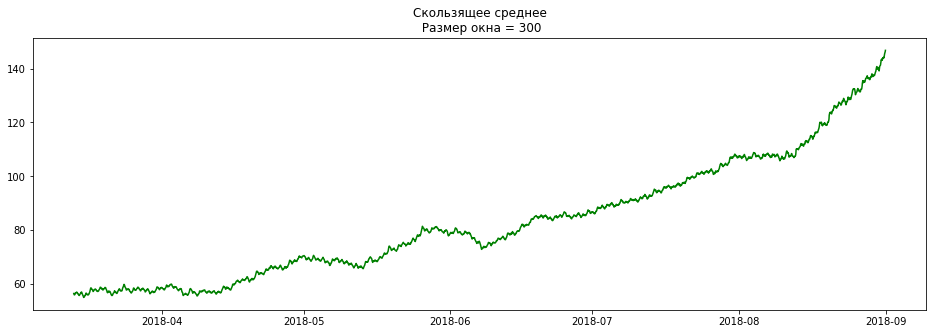

In [60]:
moving_average(taxi.num_orders, 300)

In [61]:
train_start,train_end = '2018-04-01','2018-07-01'
test_start,test_end = '2018-07-02','2018-09-01'
train = taxy['num_orders'][train_start:train_end]
test = taxy['num_orders'][test_start:test_end]

In [102]:
sarimax = sm.tsa.statespace.SARIMAX(train, seasonal_order=(24,1,24,1),
                                enforce_stationarity=False, enforce_invertibility=False).fit()

# 4. Тестирование

In [87]:
def plot_compare(predictions_model):
    predictions = pd.DataFrame(predictions_model)
    predictions.index = target_test.index
    predictions.plot(figsize=(16,5), title = 'График временного ряда')
    target_test.plot(figsize=(16,5), title = 'График временного ряда')

    plt.show()


In [55]:
model_Linear_predict = model_Linear.predict(features_test)
print('RMSE:', mean_squared_error(target_test, model_Linear_predict)**0.5)

RMSE: 36.480891284028566


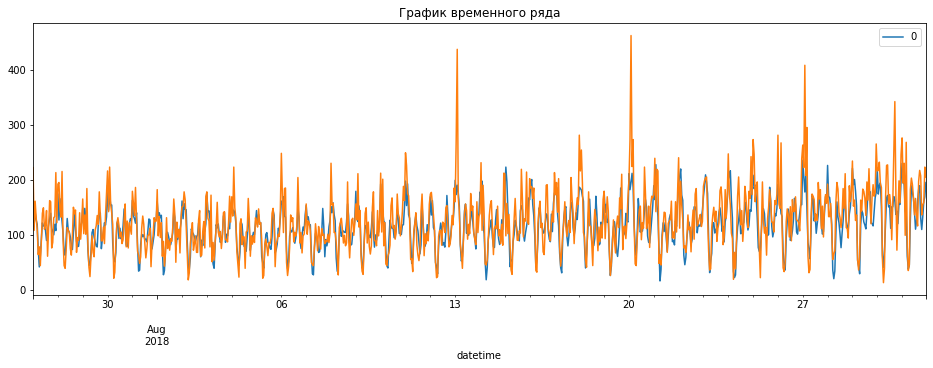

In [88]:
plot_compare(model_Linear_predict)

In [56]:
gradient_model_predict = gradient_model.predict(features_test)
print('RMSE:', mean_squared_error(target_test, gradient_model_predict)**0.5)

RMSE: 39.55460206120735


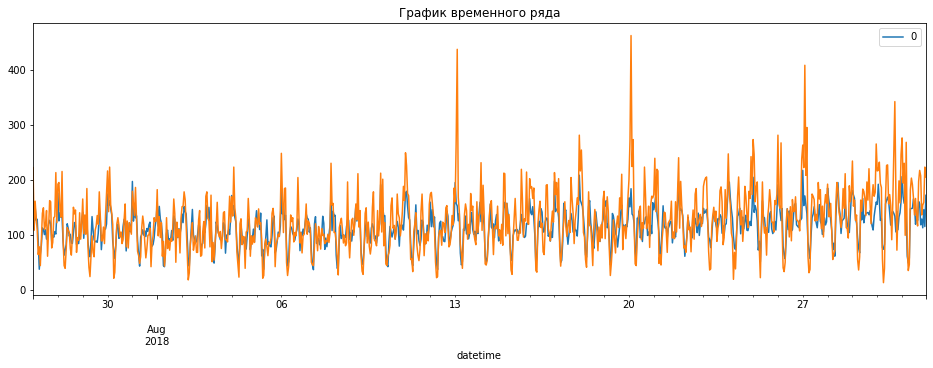

In [89]:
plot_compare(gradient_model_predict)

In [57]:
model_CatBoost_predictions = model_CatBoost.predict(features_test)
print('RMSE:', mean_squared_error(target_test, model_CatBoost_predictions)**0.5)

RMSE: 51.112227037753264


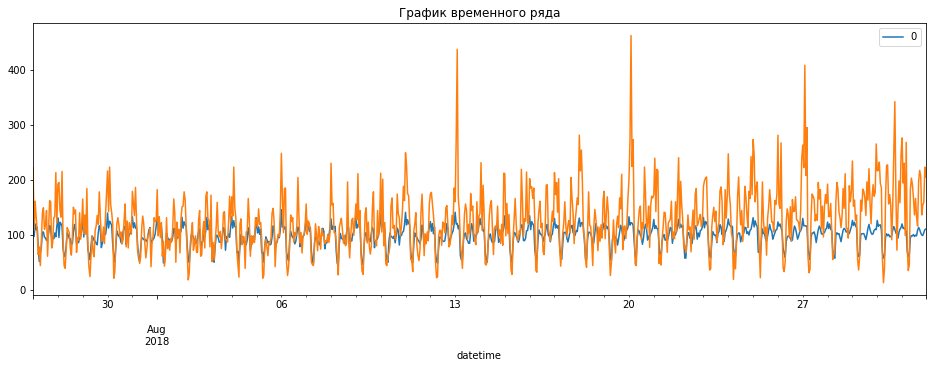

In [90]:
plot_compare(model_CatBoost_predictions)

In [58]:
model_XGBoost_predictions = bst.predict(dtest)
print('RMSE',mean_squared_error(target_test, model_XGBoost_predictions)**0.5)

RMSE 50.62359742079883


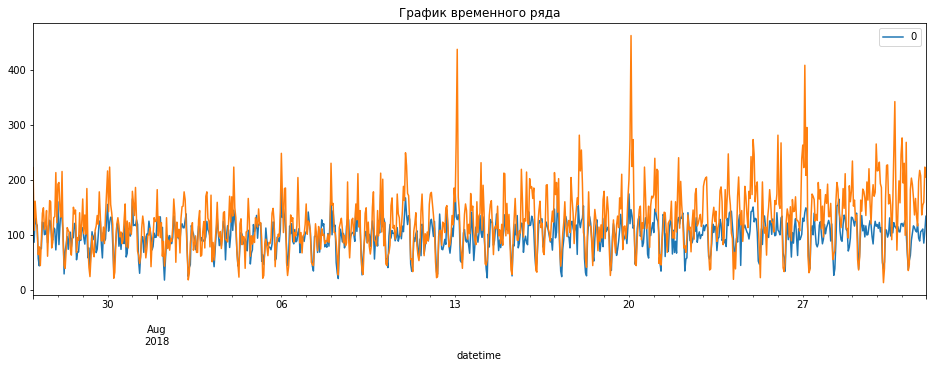

In [91]:
plot_compare(model_XGBoost_predictions)

In [103]:
predictions_sarimax = sarimax.predict(test.index[0], test.index[-1], dynamic = True)
print('RMSE',mean_squared_error(test, predictions_sarimax)**0.5)

RMSE 47.705546085191756


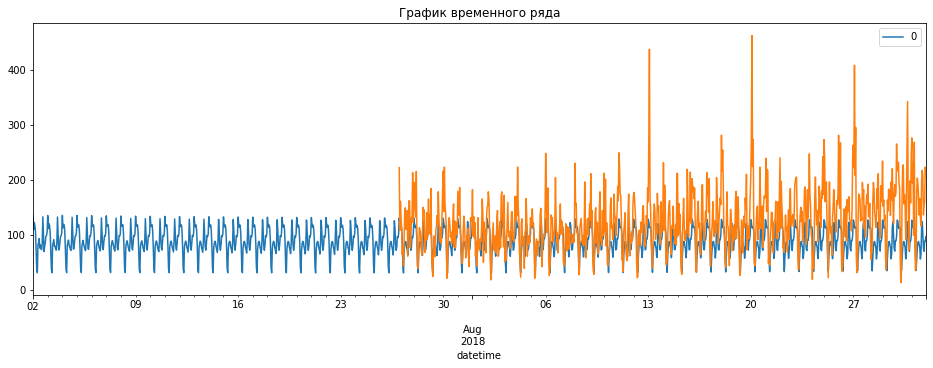

In [104]:
predictions = pd.DataFrame(predictions_sarimax)
predictions.index = test.index
predictions.plot()
target_test.plot(figsize=(16,5), title = 'График временного ряда')